In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import io, signal
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding
from scipy.stats import ttest_1samp
import seaborn as sns
# sns.set_theme()
import os

import sys
sys.path.append(sys.path[0][:-27])

import imp

from ikd import utils, core, evaluate, datasets, epca
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)
imp.reload(epca)

<module 'ikd.epca' from 'd:\\GT\\Lab\\ikd NeurIPS 2022\\src\\ikd\\epca.py'>

In [11]:
if os.path.exists("exp6_py2mat.mat") is False:
    backward = 'sqrt'
    exp6_py2mat = []
    trial = 0
    for mouse_name in ["Mil", "Fiv", "Con"]:
        for day in range(1, 6):
            for epoch in [2, 4]:
                z_true, spikes = datasets.hc_6(mouse_name, day, epoch, show=False)
                d_latent = z_true.shape[1]
                spikes = spikes.astype(float)
                spikes_dense = utils.backward(spikes, method=backward)

                rng = np.random.default_rng(trial)
                z_rand = rng.uniform(low=-0.5, high=0.5, size=(z_true.shape[0], 2))

                z_pca = utils.median_filter(PCA(n_components=z_true.shape[1]).fit_transform(spikes_dense)) # pca
                z_kernel_pca = KernelPCA(n_components=d_latent, kernel='sigmoid').fit_transform(spikes_dense)
                z_le = SpectralEmbedding(n_components=d_latent).fit_transform(spikes_dense)
                z_epca = utils.median_filter(epca.exp_fam_pca(spikes, "poisson", r=z_true.shape[1])[3]) # Liu's epca

                cov_spikes = np.cov(spikes_dense)
                variance_spikes = 2 * np.mean(cov_spikes)
                cov_spikes_th = utils.filt_cov_samp(cov_spikes, variance_spikes)
                cov_spikes_th = signal.convolve2d(cov_spikes_th, 1/121 * np.ones((11, 11)), boundary='symm', mode='same')
                variance_spikes = 2 * np.mean(cov_spikes_th)
                cov_spikes_th = utils.filt_cov_samp(cov_spikes_th, variance_spikes)
                z_ikd = utils.median_filter(core.ikd(cov_spikes_th, z_true.shape[1], kernel="squared exponential", variance=variance_spikes, length_scale=1)[0])

                sol = epca.exp_fam_pca(spikes.T, "poisson", r=spikes.shape[1])
                firing_rates_est = epca.wiener_filter(sol[0], spikes.T, "poisson").T
                x_est = utils.backward(firing_rates_est, method=backward)
                cov_est = np.cov(x_est)
                variance_est = 2 * np.mean(cov_est)
                cov_est_th = utils.filt_cov_samp(cov_est, variance_est)
                cov_est_th = signal.convolve2d(cov_est_th, 1/121 * np.ones((11, 11)), boundary='symm', mode='same')
                variance_est = 2 * np.mean(cov_est_th)
                cov_est_th = utils.filt_cov_samp(cov_est_th, variance_est)
                z_eikd = utils.median_filter(core.ikd(cov_est_th, z_true.shape[1], kernel="squared exponential", variance=variance_spikes, length_scale=1)[0])

                exp6_py2mat.append({"mouse_name": mouse_name, "day": day, "epoch": epoch , "z_true": z_true, "spikes": spikes, "firing_rates_est": firing_rates_est, "z_pca": z_pca, 'z_kernel_pca': z_kernel_pca, 'z_le': z_le, "z_epca": z_epca, "z_ikd": z_ikd, "z_eikd": z_eikd})
                print(trial, mouse_name, day, epoch)
                trial += 1
    io.savemat("exp6_py2mat.mat", {"exp6_py2mat": exp6_py2mat})

In [12]:
exp6_py2mat = io.loadmat("exp6_py2mat.mat", simplify_cells=True)['exp6_py2mat']
n_trials = len(exp6_py2mat)
result = np.zeros(n_trials)
df_list = []
trial = 0
day_dict = {'Mil': [1, 2, 3, 4, 5],
    'Fiv': [1, 2, 3, 4, 5],
    'Con': [1, 2, 3, 4, 5]}
method_list = ['pca', 'kernel_pca', 'le', 'epca', 'ikd', 'eikd', 'plds']
for mouse_name in day_dict.keys():
        for day in day_dict[mouse_name]:
            for epoch in [2, 4]:
                if trial in [8, 9, 17]:
                    trial += 1
                    continue
                
                exp6_mat2py = io.loadmat(f"outputs/exp6_mat2py_{mouse_name}_{day}_{epoch}.mat", simplify_cells=True)['result']

                z_true = exp6_mat2py['z_true']
                n_neurons = exp6_py2mat[trial]['spikes'].shape[1]
                df_list.append(pd.DataFrame({
                    'Initial $R^2$': list(map(lambda x: r2_score(z_true, utils.align(z_true, x)), [exp6_mat2py[i]['init'] for i in method_list])),
                    'PGPLVM $R^2$': list(map(lambda x: r2_score(z_true, utils.align(z_true, x)), [exp6_mat2py[i]['pgplvm'] for i in method_list])),
                    "PLL": [exp6_mat2py[i]['pll'] for i in method_list],
                    "method": ['PCA', 'kernel PCA', 'Laplacian eigenmaps', '$e$PCA', 'IKD', '$e$IKD', 'PLDS'],
                    "mouse_name": mouse_name,
                    "day": day,
                    "epoch": epoch,
                    "n_neurons": n_neurons}))
                trial += 1
df = pd.concat(df_list, ignore_index=True)

df2 = df[df.mouse_name != 'Fiv']

In [13]:
for j in ['PCA', 'kernel PCA', 'Laplacian eigenmaps', '$e$PCA', 'PLDS']:
    print(j, end='')
    for metric in ['PGPLVM $R^2$', 'PLL']:
        for i in ['IKD', '$e$IKD']:
            sol = ttest_1samp(df2[df2.method == j][metric].values - df2[df2.method == i][metric].values, 0, alternative='less')
            print(f' & ({sol[0]:+.2f}, {sol[1]:.2f})', end='')
    print(' \\\\')

PCA & (-2.60, 0.01) & (-2.42, 0.01) & (-0.97, 0.17) & (-1.84, 0.04) \\
kernel PCA & (-4.73, 0.00) & (-4.86, 0.00) & (-1.81, 0.04) & (-2.90, 0.00) \\
Laplacian eigenmaps & (+0.20, 0.58) & (+0.07, 0.53) & (-0.97, 0.17) & (-1.77, 0.05) \\
$e$PCA & (-3.28, 0.00) & (-3.21, 0.00) & (-1.31, 0.10) & (-1.76, 0.05) \\
PLDS & (+2.12, 0.98) & (+1.86, 0.96) & (+0.94, 0.82) & (+0.55, 0.70) \\


C:\Users\chengrui\AppData\Local\Temp/ipykernel_5572/2287706942.py:22: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


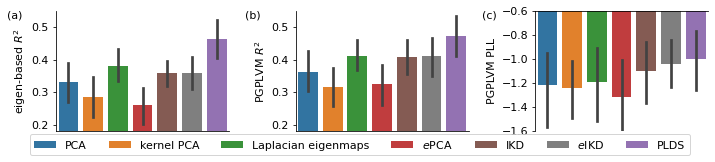

In [14]:
plt.rcParams.update({'font.size': 11})
ax = sns.barplot(x='mouse_name', y='Initial $R^2$', hue='method', data=df2, palette=['C0', 'C1', 'C2', 'C3', 'C5', 'C7', 'C4'])
handles, labels = ax.get_legend_handles_labels()
plt.close()

fig, axs = plt.subplots(1, 3, figsize=(10, 2), constrained_layout=True)
sns.barplot(x='method', y='Initial $R^2$', data=df2, ax=axs[0], palette=['C0', 'C1', 'C2', 'C3', 'C5', 'C7', 'C4']).set(xlabel=None, ylim=(0.18, 0.55))
sns.barplot(x='method', y='PGPLVM $R^2$', data=df2, ax=axs[1], palette=['C0', 'C1', 'C2', 'C3', 'C5', 'C7', 'C4']).set(xlabel=None, ylim=(0.18, 0.55))
sns.barplot(x='method', y='PLL', data=df2, ax=axs[2], palette=['C0', 'C1', 'C2', 'C3', 'C5', 'C7', 'C4']).set(xlabel=None, ylim=(-1.6, -0.6))
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axs[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[0].set_ylabel('eigen-based $R^2$')
axs[2].set_ylabel('PGPLVM PLL')
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=7)
plt.tight_layout()
fig.text(0.01, 0.87, '(a)')
fig.text(0.34, 0.87, '(b)')
fig.text(0.67, 0.87, '(c)')
plt.savefig('empirical.pdf', bbox_inches='tight')